In [39]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu 

In [40]:
import constants as c
import helpers as h 
h.latex(True)

2025-02-07 20:57:41 - analysis-helpers - INFO - Enabling LaTeX for matplotlib.


In [41]:
d = pd.read_csv(c.CURRENT_NO_COVARIATES_DF)
d = h.add_helper_cols(d)

2025-02-07 20:57:41 - analysis-helpers - INFO - Found 192 tracts with at least one FloodNet sensor.
2025-02-07 20:57:41 - analysis-helpers - INFO - Found 2171 311 requests.
2025-02-07 20:57:41 - analysis-helpers - INFO - Found 878 tracts with at least one 311 report.
2025-02-07 20:57:41 - analysis-helpers - INFO - Found 1001 tracts with no DEP flooding.


In [42]:
high_flood_risk_cutoff = d[d['at_least_one_positive_image_by_area'] == 1]['p_y'].quantile(0.25)
print('High flood risk cutoff:', high_flood_risk_cutoff)

High flood risk cutoff: 0.007261037923233075


In [43]:
d = d[['p_y', 'any_311_report', 'any_sensors',
       'ft_elevation_min', 'ft_elevation_mean', 'ft_elevation_max', 'dep_moderate_1_frac', 'dep_moderate_2_frac']]



In [44]:
row_mapping = {
    'any_311_report': 'Any 311 Report in tract?',
    'n_311_reports': '\# of 311 Reports in tract',
    'any_sensors': 'Any FloodNet sensors in tract?',
    'n_floodnet_sensors': '\# of FloodNet sensors in tract',
    'dep_moderate_1_frac': r'Frac. DEP Shallow Flooding [${ft}^2$]',
    'dep_moderate_2_frac': r'Frac. DEP Deep Flooding [${ft}^2$]',
    'ft_elevation_min': 'Minimum elevation in tract [ft]',
    'ft_elevation_mean': 'Mean elevation in tract[ft]',
    'ft_elevation_max': 'Maximum elevation in tract [ft]'
}

any_311_report 1.4253390937405808
any_sensors 2.0752849651640854
ft_elevation_min 0.5372796984927742
ft_elevation_mean 0.7019832740767855
ft_elevation_max 0.830473447523692
dep_moderate_1_frac 1.393892502809781
dep_moderate_2_frac 1.2645879329068612


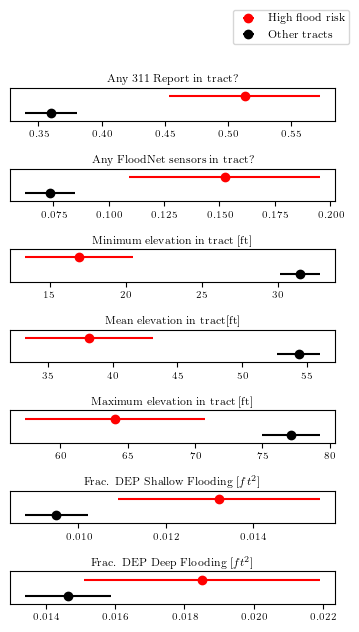

In [48]:
d['high_flood_risk'] = (d['p_y'] > high_flood_risk_cutoff) * 1.
plot_num = 0
fig = plt.figure(figsize=[4, 8])

legend_handles = []
legend_labels = []

for k in d.columns:
    if 'p_y' not in k and 'high_flood_risk' not in k:
        plot_num += 1
        ax = plt.subplot(10, 1, plot_num)
        means_by_bin = d.groupby('high_flood_risk')[k].mean()
        stds_by_bin = d.groupby('high_flood_risk')[k].std()
        bin_sizes = d.groupby('high_flood_risk').size()
        assert list(means_by_bin.index) == [0, 1]
        
        # print the ratio of the means for each feature
        print(k, means_by_bin.iloc[1] / means_by_bin.iloc[0])
        
        if plot_num == 1:
            high_risk = plt.errorbar(means_by_bin.iloc[1],
                            1, 
                            xerr=1.96 * stds_by_bin.iloc[1] / (bin_sizes.iloc[1]**0.5), 
                            color='red', 
                            fmt='o', 
                            label='High flood risk')
            other_tracts = plt.errorbar(means_by_bin.iloc[0], 
                            0, 
                            xerr=1.96 * stds_by_bin.iloc[0] / (bin_sizes.iloc[0]**0.5), 
                            color='black', 
                            fmt='o', 
                            label='Other tracts')
            legend_handles = [high_risk, other_tracts]
            legend_labels = ['High flood risk', 'Other tracts']
        else:
            plt.errorbar(means_by_bin.iloc[1],
                        1, 
                        xerr=1.96 * stds_by_bin.iloc[1] / (bin_sizes.iloc[1]**0.5), 
                        color='red', 
                        fmt='o')
            plt.errorbar(means_by_bin.iloc[0], 
                        0, 
                        xerr=1.96 * stds_by_bin.iloc[0] / (bin_sizes.iloc[0]**0.5), 
                        color='black', 
                        fmt='o')

        p_val = mannwhitneyu(d.loc[d['high_flood_risk'] == 1, k], 
                             d.loc[d['high_flood_risk'] == 0, k])[1]
        plt.ylim([-0.5, 1.5])

        
       
        
        plt.title(row_mapping[k], fontsize=8, pad=4)
        
        # Add p-value with stars to the right side
        stars = ''
        if p_val < 0.001:
            stars = '***'
        elif p_val < 0.01:
            stars = '**'
        elif p_val < 0.05:
            stars = '*'
            
        #ax.text(1.02, 1.2, f'p = {p_val:.1e}{stars}', 
        #        transform=ax.transAxes,
        #        fontsize=8,
        #        horizontalalignment='right',
        #        verticalalignment='center')
        
        plt.yticks([])
        # set x ticks font size 
        plt.xticks(fontsize=7)

plt.tight_layout()

fig.legend(legend_handles, legend_labels, 
          loc='upper right', 
          bbox_to_anchor=(0.9, 1.07), fontsize=8)

plt.subplots_adjust(right=0.85, hspace=1.5)

plt.savefig(f'{c.PAPER_PATH}/figures/external_corrs_vs_risk.pdf', dpi=200, bbox_inches='tight', pad_inches=0.025)